Detect and fit filament in an image:

- Use single point seeds (provided by user or automatically detected).
- 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("../../")
import tqdm

import anamic

import numpy as np
import matplotlib.pyplot as plt

../../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


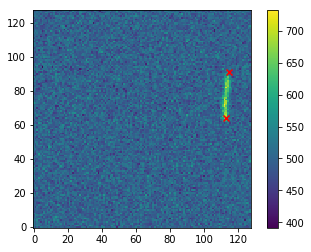

In [58]:
# Common Parameters
pixel_size = 110  # nm/pixel
image_size_pixel = 128  # pixel
n_images = 1

# Per image parameters
image_parameters = {}
image_parameters['n_mt'] = {'values': 1}
image_parameters['signal_mean'] = {'values': 700}
image_parameters['signal_std'] = {'values': 100}
image_parameters['bg_mean'] = {'values': 500}
image_parameters['bg_std'] = {'values': 24}
image_parameters['noise_factor'] = {'values': 1}

# Per microtubule parameters.
microtubule_parameters = {}
microtubule_parameters['n_pf'] = {'values': 13}
microtubule_parameters['mt_length_nm'] = {'values': 3000}
microtubule_parameters['taper_length_nm'] = {'values': 200}
microtubule_parameters['labeling_ratio'] = {'values': 0.1}

anamic.simulator.MicrotubuleSimulator.enable_cached_positions = True
image, masks, mts = anamic.fov.create_fov(image_size_pixel, pixel_size, microtubule_parameters,
                                          image_parameters, return_positions=True)

# Get the tips of the microtubule
ms = mts[0]
x_start, x_end, y_start, y_end = anamic.structure.get_mt_tips(ms.positions, coordinates_features=['x_pixel', 'y_pixel'])
seed = np.array([[x_start, y_start], [x_end, y_end]])
tip_start, tip_end = seed[0], seed[1]

plt.imshow(image, origin=[0, 0])
plt.colorbar()
plt.scatter(seed[:, 1], seed[:, 0], color='red', marker='x')

In [60]:
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 5  # pixel
args['get_thick_line_args']['line_thickness'] = 20  # pixel

args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.1

args['offset_start'] = 40  # pixel
args['offset_end'] = 20  # pixel

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 4  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

# Fit the start tip
results = anamic.fitter.microtubule_tip_fitter(tip_end, tip_start, image, **args)
line_fit_tips, x_profile, y_profile, fit_result, fit_func = results
vec = np.diff(line_fit_tips, axis=0)
new_start = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], fit_result.values['mu'])

# Fit the end tip
results = anamic.fitter.microtubule_tip_fitter(tip_start, tip_end, image, **args)
line_fit_tips, x_profile, y_profile, fit_result, fit_func = results
vec = np.diff(line_fit_tips, axis=0)
new_end = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], fit_result.values['mu'])

line = np.array([new_start[0], new_end[0]])

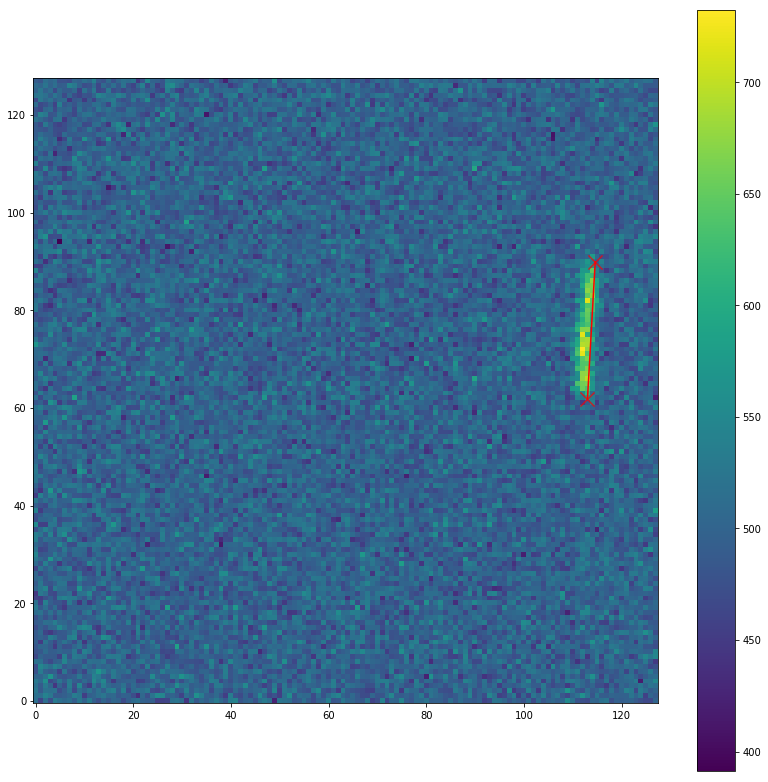

In [62]:
plt.figure(figsize=(14, 14))
plt.imshow(image, origin=[0, 0])
plt.colorbar()
plt.scatter(line[0, 1], line[0, 0], color='red', marker='x', s=200, alpha=0.7)
plt.scatter(line[1, 1], line[1, 0], color='red', marker='x', s=200, alpha=0.7)
plt.plot(line[:, 1], line[:, 0], color='red')

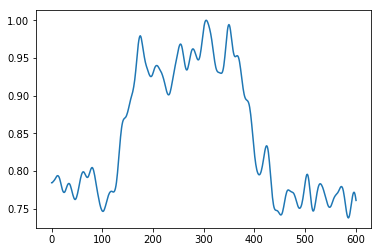

In [30]:
plt.plot(y_profile)